In [1]:
from utils import create_dataloaders
from evaluate import reconstruction_loss, evaluate_model
from AutoDecoder import AutoDecoder
from trainer import BasicTrainer

1.3 Auto Decoder

In [2]:
train_ds, train_dl, test_ds, test_dl = create_dataloaders(data_path='', batch_size=64)


In [3]:
import torch
import torch.nn as nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

latent_dim = 128

model = AutoDecoder(latent_dim)
trainer = BasicTrainer(model=model, dl=train_dl, latent_dim=model.latent_dim, device=device)
num_epochs = 500
losses = trainer.train(num_epochs=num_epochs)

Using device: cuda
Epoch [1/500], Loss: 0.4807
Epoch [2/500], Loss: 0.3830
Epoch [3/500], Loss: 0.2839
Epoch [4/500], Loss: 0.2319
Epoch [5/500], Loss: 0.2245
Epoch [6/500], Loss: 0.2144
Epoch [7/500], Loss: 0.1947
Epoch [8/500], Loss: 0.1877
Epoch [9/500], Loss: 0.1804
Epoch [10/500], Loss: 0.1762
Epoch [11/500], Loss: 0.1787
Epoch [12/500], Loss: 0.1729
Epoch [13/500], Loss: 0.1689
Epoch [14/500], Loss: 0.1638
Epoch [15/500], Loss: 0.1571
Epoch [16/500], Loss: 0.1540
Epoch [17/500], Loss: 0.1509
Epoch [18/500], Loss: 0.1490
Epoch [19/500], Loss: 0.1491
Epoch [20/500], Loss: 0.1504
Epoch [21/500], Loss: 0.1483
Epoch [22/500], Loss: 0.1457
Epoch [23/500], Loss: 0.1427
Epoch [24/500], Loss: 0.1377
Epoch [25/500], Loss: 0.1383
Epoch [26/500], Loss: 0.1372
Epoch [27/500], Loss: 0.1341
Epoch [28/500], Loss: 0.1339
Epoch [29/500], Loss: 0.1311
Epoch [30/500], Loss: 0.1258
Epoch [31/500], Loss: 0.1238
Epoch [32/500], Loss: 0.1201
Epoch [33/500], Loss: 0.1222
Epoch [34/500], Loss: 0.1212
Epoc

In [24]:
# Evaluation on the training dataset
train_latents = torch.nn.Parameter(torch.randn(len(train_dl.dataset), model.latent_dim).to(device))
opt = torch.optim.Adam([train_latents], lr=1e-3)
test_loss = evaluate_model(model=model, test_dl=train_dl, opt=opt, latents=train_latents, epochs=1000, device=device)
print(f"AD has finished train evaluation with a train loss of {test_loss}.")

# Evaluation on the test dataset
latents = torch.nn.Parameter(torch.randn(len(test_dl.dataset), model.latent_dim).to(device))
opt = torch.optim.Adam([latents], lr=1e-3)
test_loss = evaluate_model(model=model, test_dl=test_dl, opt=opt, latents=latents, epochs=1000, device=device)
print(f"AD has finished test evaluation with a test loss of {test_loss}.")


AD has finished train evaluation with a train loss of 0.02666552329901606.
AD has finished test evaluation with a test loss of 0.08844717731699347.


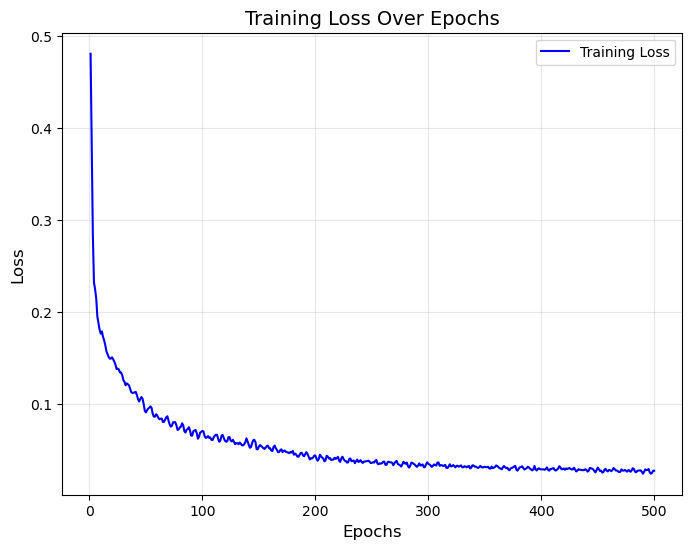

In [9]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Plot the losses
plt.figure(figsize=(8, 6))
# print(test_loss)
plt.plot(epochs, losses, label='Training Loss', color='blue')
# plt.plot(epochs,test_loss , label='Test Loss', color='orange')  

# Adding titles and labels
plt.title('Training Loss Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# Adding a legend
plt.legend(fontsize=10)

# Adding grid
plt.grid(alpha=0.3)

# Show the plot
plt.show()

In [23]:
# Randomly sample 5 indices from the test dataset
import random
import utils
random.seed(42)
sampled_indices = random.sample(range(len(latents)), 5)

# Extract the corresponding vectors (input data) and their labels
sampled_latents = [latents[i] for i in sampled_indices]  # Only selecting input data, not labels

# Convert to a single tensor (optional)
sampled_latents_tensor = torch.stack(sampled_latents)
random_latents_tensor = torch.randn_like(sampled_latents_tensor)

print("Sampled Vectors Shape:", sampled_latents_tensor.shape)  # Should be (5, *) depending on your data shape
print("Random Vectors Shape:", random_latents_tensor.shape)  # Should be (5, *) depending on your data shape

sampled_test_images = model(sampled_latents_tensor).view(-1, 1, 28, 28)
random_test_images = model(random_latents_tensor).view(-1, 1, 28, 28)

print("Sampled Images Shape:", sampled_test_images.shape)  # Should be (5, *) depending on your data shape
utils.save_images(sampled_test_images, "AD_results/generated/sampled_test_images.png")
utils.save_images(random_test_images, "AD_results/generated/random_test_images.png")
# import matplotlib.pyplot as plt
# plt.imshow(sampled_test_images.detach().cpu().numpy().reshape(28, 28), cmap='gray')
# plt.show()

Sampled Vectors Shape: torch.Size([5, 128])
Random Vectors Shape: torch.Size([5, 128])
Sampled Images Shape: torch.Size([5, 1, 28, 28])


In [11]:
from utils import plot_tsne
utils.plot_tsne(test_ds, latents, f"AD_results/tsne/tsne_test.png")

<Figure size 800x600 with 0 Axes>

VAD Part

In [1]:
from utils import create_dataloaders
from evaluate import reconstruction_loss, evaluate_model
from VariationalAutoDecoder import VariationalAutoDecoder
from trainer import VADTrainer

In [2]:
train_ds, train_dl, test_ds, test_dl = create_dataloaders(data_path='', batch_size=64)


In [3]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

latent_dim = 128

models = []
trainers = []

# beta_values = [0.1, 1, 10, 100, 500, 1000]
beta_values = [200, 300, 500]
for beta in beta_values:
    model = VariationalAutoDecoder(latent_dim, device=device)
    models.append(model)
    trainer = VADTrainer(model=model, dl=train_dl, latent_dim=model.latent_dim, device=device, beta=beta)
    trainers.append(trainer)
    
for trainer in trainers:
    trainer.train(num_epochs=350)


Using device: cuda
Epoch [1/350], Loss: 40672.8723
Epoch [2/350], Loss: 37561.4243
Epoch [3/350], Loss: 35403.7803
Epoch [4/350], Loss: 34148.6423
Epoch [5/350], Loss: 33152.8794
Epoch [6/350], Loss: 32544.6323
Epoch [7/350], Loss: 32163.6489
Epoch [8/350], Loss: 31757.8673
Epoch [9/350], Loss: 31354.0328
Epoch [10/350], Loss: 31095.6456
Epoch [11/350], Loss: 30722.6014
Epoch [12/350], Loss: 30393.0782
Epoch [13/350], Loss: 30154.4926
Epoch [14/350], Loss: 29803.0768
Epoch [15/350], Loss: 29520.1035
Epoch [16/350], Loss: 29332.0758
Epoch [17/350], Loss: 28949.1434
Epoch [18/350], Loss: 28714.1139
Epoch [19/350], Loss: 28508.0255
Epoch [20/350], Loss: 28252.1968
Epoch [21/350], Loss: 28043.5146
Epoch [22/350], Loss: 27784.6937
Epoch [23/350], Loss: 27517.7429
Epoch [24/350], Loss: 27252.7223
Epoch [25/350], Loss: 27060.4987
Epoch [26/350], Loss: 26856.2653
Epoch [27/350], Loss: 26590.8492
Epoch [28/350], Loss: 26373.8333
Epoch [29/350], Loss: 26173.0114
Epoch [30/350], Loss: 25929.3774


In [5]:
###### Evaluation on the test dataset

latents_lst = []
for model in models:
    mu_test = torch.randn(len(test_dl.dataset), latent_dim, device=device, requires_grad=True)
    sigma_test = torch.randn(len(test_dl.dataset), latent_dim, device=device, requires_grad=True)
    test_latents = torch.nn.parameter.Parameter(torch.stack([mu_test, sigma_test], dim=1)).to(device)
    
    opt = torch.optim.Adam([test_latents], lr=5e-3)
    test_loss = evaluate_model(model=model, test_dl=test_dl, opt=opt, latents=test_latents, epochs=700, device=device)
    latents_lst.append(test_latents)
    print(f"AD has finished test evaluation with a test loss of {test_loss}.")

    # Evaluation on the training dataset
    mu_test = torch.randn(len(test_dl.dataset), latent_dim, device=device, requires_grad=True)
    sigma_test = torch.randn(len(test_dl.dataset), latent_dim, device=device, requires_grad=True)
    train_latents = torch.nn.parameter.Parameter(torch.stack([mu_test, sigma_test], dim=1)).to(device)
    opt = torch.optim.Adam([train_latents], lr=1e-3)
    train_loss = evaluate_model(model=model, test_dl=train_dl, opt=opt, latents=train_latents, epochs=700, device=device)
    print(f"AD has finished train evaluation with a train loss of {train_loss}.")


AD has finished test evaluation with a test loss of 0.17914448771625757.
AD has finished train evaluation with a train loss of 0.18829396553337574.
AD has finished test evaluation with a test loss of 0.18555865716189146.
AD has finished train evaluation with a train loss of 0.19398182537406683.
AD has finished test evaluation with a test loss of 0.1944260774180293.
AD has finished train evaluation with a train loss of 0.20323046389967203.


In [6]:
# Randomly sample 5 indices from the test dataset
import random
import utils


random.seed(777)
sampled_indices = random.sample(range(len(test_latents)), 5)

samp = []
for i, test_latents in enumerate(latents_lst):
    # Extract the corresponding vectors (input data) and their labels
    sampled_latents = [test_latents[i] for i in sampled_indices]  # Only selecting input data, not labels
    
    # Convert to a single tensor (optional)
    sampled_latents_tensor = torch.stack(sampled_latents)
    samp.append(sampled_latents_tensor)
    
    random_latents_tensor = torch.randn((5,128), device=device)
    
    print("Sampled Vectors Shape:", sampled_latents_tensor.shape)  # Should be (5, *) depending on your data shape
    print("Random Vectors Shape:", random_latents_tensor.shape)  # Should be (5, *) depending on your data shape
    
    sampled_test_images = models[i](sampled_latents_tensor).view(-1, 1, 28, 28)
    random_test_images = models[i].david_forward(random_latents_tensor).view(-1, 1, 28, 28)
    
    utils.save_images(sampled_test_images, f"VAD_results/generated/sampled_test_images_{beta_values[i]}.png")
    utils.save_images(random_test_images, f"VAD_results/generated/random_test_images_{beta_values[i]}.png")


Sampled Vectors Shape: torch.Size([5, 2, 128])
Random Vectors Shape: torch.Size([5, 128])
Sampled Vectors Shape: torch.Size([5, 2, 128])
Random Vectors Shape: torch.Size([5, 128])
Sampled Vectors Shape: torch.Size([5, 2, 128])
Random Vectors Shape: torch.Size([5, 128])


In [7]:
from utils import plot_tsne

for i,model in enumerate(models):
    result_test_latents = model.reparameterization_trick(test_latents)
    utils.plot_tsne(test_ds, result_test_latents, f"VAD_results/tsne/tsne_test_{beta_values[i]}.png")


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

Interpolation

In [8]:
# #INTERPOLATION

#INTERPOLATION CODE !!

# need to check beforehand that the picked pictures will be of diffrenet classes
sampled_latents = [result_test_latents[sampled_indices[0]],  result_test_latents[sampled_indices[1]]]

#they asked for 5 differenet equally distrubed values, can probably do this using np but whatever
# weights = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
weights = [0, 0.25, 0.5, 0.75, 1]

interpolated_latents = [w * sampled_latents[0] + (1 - w) * sampled_latents[1] for w in weights]
interpolated_latents_tensor = torch.stack(interpolated_latents)
print(interpolated_latents_tensor.shape)
interpolated_images = model.decoder(interpolated_latents_tensor).view(-1, 1, 28, 28)


utils.save_images(interpolated_images, "interpolted_image_normal_dist.png")

torch.Size([5, 128])
